In [1]:

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.qucf_read as qucf_r
import pylib.measurement as mse
import kvn
import LCHS

23791
/media/work/docs/codes/QuCF/scripts-py


In [2]:
path_save_ = "./jupyter-notebooks/NL/results/"
colors_ = ["blue", "red", "green", "gray", "black"]
for i in range(30):
    plt.close()

# ------------------------------------------------------------------------
def get_max_ABS_err(t_ref, psi_ref, t_LCHS, psi_LCHS, coef_sign):
    max_abs_err = 0
    for id_var in range(2):
        for it in range(len(t_LCHS)):
            t1 = t_LCHS[it]
            v_ref = np.interp(t1, t_ref, psi_ref[:, id_var])  
            err = np.max(np.abs(v_ref - coef_sign * psi_LCHS[it, id_var]))
            if max_abs_err < err:
                max_abs_err = err
    print("max. abs. err: {:0.3e}".format(max_abs_err))
    return

# ------------------------------------------------------------------------
def get_max_REL_err(t_ref, psi_ref, t_LCHS, psi_LCHS, coef_sign):
    max_err = 0
    for id_var in range(2):
        for it in range(len(t_LCHS)):
            t1 = t_LCHS[it]
            v_ref = np.interp(t1, t_ref, psi_ref[:, id_var])  
            err = np.max(np.abs(v_ref - coef_sign * psi_LCHS[it, id_var]))
            if np.abs(v_ref) > 1e-6:
                err /= np.abs(v_ref)
            if max_err < err:
                max_err = err
    print("max. rel. err: {:0.3e}".format(max_err))
    return

In [3]:
# --------------------------------------------------------
# --- Parameters: single time ---
# --------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)

# ---------------------------------------------------------
# --- Choose weak or strong dissipation ---
sel_case_ = 2
k_max_, nk_ = 10, 5

str_case_ = ""
if sel_case_ == 1:
    coef_sign_ = 1
    str_case_ = "WD"
if sel_case_ == 2:
    coef_sign_ = 1
    str_case_ = "SD"

coef_lcu_ = 2.

# --- k -grid --
Nk_ = 1 << nk_
dk_ = 2. * k_max_ / (Nk_ - 1)
theta_grid_ = np.linspace(-np.pi/2., np.pi/2., Nk_)
k_grid_     = k_max_ * np.sin(theta_grid_)

# Chosen Hamiltonian * i:
Hi_ = kvn.get_case_Hi(sel_case_)

# Hermitian and anti-Hermitian parts of Hi_:
AL_, AH_ = mix.get_herm_aherm_parts(Hi_)

Bm_ = k_max_ * AL_
C_ = AH_ + Bm_
_, norm_of_C, _ = mix.compute_normalized_matrix(C_, "C", True)
BE_norm_ = coef_lcu_ * norm_of_C  # double because of LCU
print("BE-norm: {:0.3e}".format(BE_norm_))
print()
del norm_of_C

# --- normalized matrices to BE ---
AH_norm_ = AH_ / BE_norm_
Bm_norm_ = Bm_ / BE_norm_
_, _, nonsparsity_AH = mix.compute_normalized_matrix(AH_norm_, "AH_norm_", True)
_, _, nonsparsity_Bm = mix.compute_normalized_matrix(Bm_norm_, "Bm_norm_", True)

# --- initial state ---
psi_init_ = kvn.get_initial_state()

# ---------------------------------------------------------
# --- Parameters for the reference signal ---
nt_     = 12
t_max_  = 4

Nt_ = 1 << nt_
t_  = np.linspace(0, t_max_, Nt_)
dt_ = np.diff(t_)[0]

# --- reference computation ---
psi_ref_ = kvn.ref_computation(t_, Hi_, psi_init_)
print("Done")

--- Strong non-Hermiticity ---
Matrix C:	 nonsparsity, coefnorm: 2, 2.236e+01
BE-norm: 4.472e+01

Matrix AH_norm_:	 nonsparsity, coefnorm: 2, 1.000e-01
Matrix Bm_norm_:	 nonsparsity, coefnorm: 1, 2.236e-01

--- refence computation ---
sum psi[RK-max-time]**2: 2.174e-02
Done


In [4]:
# ------------------------------------------------------------------
# --- LCHS-python simulation ---
# ------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)
def computation_LCHS_py():
    step_t_id = 100
    psi_LCHS_py = np.zeros((Nt_, 2), dtype = complex)
    counter_t = -1
    t_LCHS_py = np.zeros(Nt_)
    for it in range(0, Nt_, step_t_id):
        counter_t += 1
        t_LCHS_py[counter_t] = t_[it]
        psi_LCHS_py[counter_t, :] = kvn.LCHS_computation_EFF(
            k_grid_, t_LCHS_py[counter_t],
            Hi_, psi_init_,  
        )

    t_LCHS_py = t_LCHS_py[:counter_t+1]
    psi_LCHS_py = psi_LCHS_py[:counter_t+1, :]
    print("Done.")
    return psi_LCHS_py, t_LCHS_py, step_t_id
# -------------------------------------------
psi_LCHS_py, t_LCHS_py, step_t_id = computation_LCHS_py()
get_max_ABS_err(t_, psi_ref_, t_LCHS_py, psi_LCHS_py, 1.0)

Done.
max. abs. err: 6.760e-02


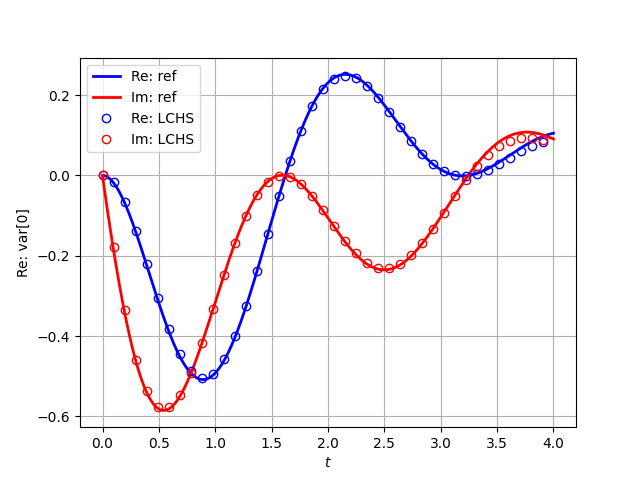

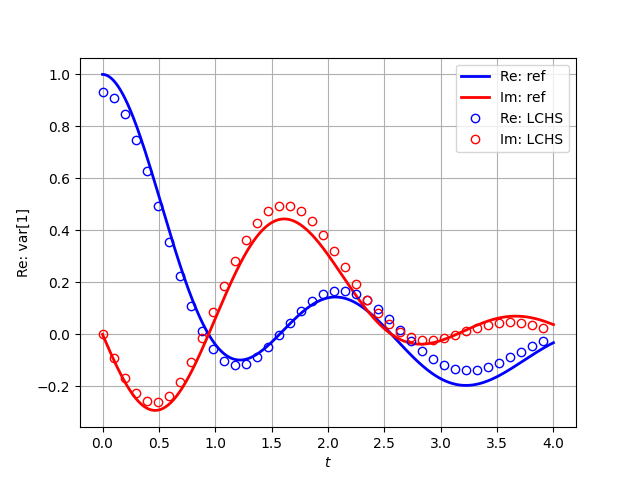

In [5]:
# ------------------------------------------------------------------
# --- Plottting the reference and the LCHS-python computations ---
# ------------------------------------------------------------------
mix.reload_module(kvn)
kvn.compare_plots_ref_LCHS_py(t_, t_LCHS_py, psi_ref_, psi_LCHS_py, id_var = 0)
kvn.compare_plots_ref_LCHS_py(t_, t_LCHS_py, psi_ref_, psi_LCHS_py, id_var = 1)

In [5]:
# ------------------------------------------------------------
# --- Parameters for the BE ---
# ------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)

def compute_angles_2x2(A_norm, nonsparsity, str_A):
    ay_00, az_00 = mix.calc_angles_from_a_value(A_norm[0,0] * nonsparsity)
    ay_01, az_01 = mix.calc_angles_from_a_value(A_norm[0,1] * nonsparsity)
    ay_10, az_10 = mix.calc_angles_from_a_value(A_norm[1,0] * nonsparsity)
    ay_11, az_11 = mix.calc_angles_from_a_value(A_norm[1,1] * nonsparsity)
  
    print("ay_00_{:s}  {:0.12e}".format(str_A, ay_00))
    if az_00 is not None:
        print("az_00_{:s}  {:0.12e}".format(str_A, az_00))

    print("ay_01_{:s}  {:0.12e}".format(str_A, ay_01))
    if az_01 is not None:
        print("az_01_{:s}  {:0.12e}".format(str_A, az_01))

    print("ay_10_{:s}  {:0.12e}".format(str_A, ay_10))
    if az_10 is not None:
        print("az_10_{:s}  {:0.12e}".format(str_A, az_10))

    print("ay_11_{:s}  {:0.12e}".format(str_A, ay_11))
    if az_11 is not None:
        print("az_11_{:s}  {:0.12e}".format(str_A, az_11))
    return
# --------------------------------------------------------------------------------------------  
# 
t_qc_ = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])  # non-normalized time points
# t_qc_ = np.array([0.5, 1.0, 1.5, 2.0])  # non-normalized time points

# --- Path with the QuCF simulation ---
path_qucf_ = "../QuCF/simulations/LCHS/LCHS-tests/"
if sel_case_ == 1:
    path_qucf_ += "Eff-WD-"
if sel_case_ == 2:
    path_qucf_ += "EFF-SD-"

path_qucf_ += "kmax{:d}".format(int(k_max_))
path_qucf_ += "-AA"

# --- Print parameters ---
print("Chosen parameters for the LCHS-QuCF simulation")
print("kmax, nk, dk:\t {:0.3f}, {:d}, {:0.3e}".format(k_max_, nk_, dk_))
print("LCHS-QuCF path:\t {:s}".format(path_qucf_))
print()

# --- The number of qubits for encoding variables ---
print("\n//--- For data ---")
print("nx \t{:d}".format(1))  # 0-D problem

# --- Compute angles for the herm. and a-herm. matrices ---
print("\n//--- The angles for the BE oracles ---")
if nonsparsity_AH > 0:
    compute_angles_2x2(coef_lcu_ * AH_norm_,  nonsparsity_AH, "H")
    print()
if nonsparsity_Bm > 0:
    compute_angles_2x2(coef_lcu_ * Bm_norm_,  nonsparsity_Bm, "m")

# --- Compute angles for the k-sin-grid ---
print("\n//--- k-grid ---")
alpha_k0 = - np.pi/2.
alpha_k1 = np.abs(alpha_k0) * Nk_/(Nk_ - 1)

print("k_max\t {:0.3f} ".format(k_max_))
print("nk \t{:d}".format(nk_))
print("alpha_k0_pih \t{:0.12e}".format(alpha_k0))
print("alpha_k1_pih \t{:0.12e}".format(alpha_k1))

# --- Compute angles for the initialization circuit ---
print("\n//--- The angles for the initialization ---")
kvn.compute_angles_initialization(psi_init_)
print()

# --- time moments ---
# BE_norm takes into account the entire matrix nonsparsity
print(" --- time moments ---")
for it in range(len(t_qc_)):
    t_qsp = BE_norm_ * t_qc_[it]
    print("t = {:0.3e}".format(t_qsp))

Chosen parameters for the LCHS-QuCF simulation
kmax, nk, dk:	 10.000, 5, 6.452e-01
LCHS-QuCF path:	 ../QuCF/simulations/LCHS/LCHS-tests/EFF-SD-kmax10-AA


//--- For data ---
nx 	1

//--- The angles for the BE oracles ---
ay_00_H  2.962467838711e+00
ay_01_H  2.781885654005e+00
ay_10_H  2.781885654005e+00
ay_11_H  2.962467838711e+00

ay_00_m  2.214297435588e+00
ay_01_m  3.141592653590e+00
ay_10_m  3.141592653590e+00
ay_11_m  3.141592653590e+00

//--- k-grid ---
k_max	 10.000 
nk 	5
alpha_k0_pih 	-1.570796326795e+00
alpha_k1_pih 	1.621467176046e+00

//--- The angles for the initialization ---
ay_init  3.141592653590e+00

 --- time moments ---
t = 2.236e+01
t = 4.472e+01
t = 6.708e+01
t = 8.944e+01
t = 1.118e+02
t = 1.342e+02
t = 1.565e+02
t = 1.789e+02


In [12]:
# --------------------------------------------------------
# --- Check block-encoding ---
# --------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_r)
def check_BE(B_ref):
    dd_loc = qucf_r.read_matrix_sparse(path_qucf_, "test.hdf5") 
    B_rec = dd_loc["A"].form_dense_matrix()

    print()
    mix.print_matrix(B_ref)

    print()
    mix.print_matrix(B_rec)


    mix.compare_matrices_dense(B_ref, B_rec, flag_return_err=True)
    return
# --------------------------------------------------------
# B_ref = np.array(AH_norm_)
B_ref = np.array(Bm_norm_)

check_BE(B_ref)
del B_ref

Reading the matrix from: N_5_OUTPUT.hdf5
from the path: ../QuCF/simulations/LCHS/LCHS-tests/EFF-SD-kmax10-AA
date of the simulation:  09-01-2024 14:34:47
matrix name:  U
N = 2

--- 0 ---
 0.224+0.000j  0.000+0.000j
--- 1 ---
 0.000+0.000j  0.000+0.000j

--- 0 ---
 0.224+0.000j  0.000+0.000j
--- 1 ---
 0.000+0.000j -0.000+0.000j
log10|max.err|:  -12.640669847378742




Reading the file ../QuCF/simulations/LCHS/LCHS-tests/EFF-SD-kmax10-AA/test_1_OUTPUT.hdf5...
Name of the simulation is test
Simulation has been performed  09-03-2024 13:10:48
success prob: 8.354432754925e-01
QuCF: kmax: 1.000e+01
nk: 5


Reading the file ../QuCF/simulations/LCHS/LCHS-tests/EFF-SD-kmax10-AA/test_2_OUTPUT.hdf5...
Name of the simulation is test
Simulation has been performed  09-03-2024 13:10:48
success prob: 4.055823122061e-01
QuCF: kmax: 1.000e+01
nk: 5


Reading the file ../QuCF/simulations/LCHS/LCHS-tests/EFF-SD-kmax10-AA/test_3_OUTPUT.hdf5...
Name of the simulation is test
Simulation has been performed  09-03-2024 13:10:48
success prob: 2.837852065070e-01
QuCF: kmax: 1.000e+01
nk: 5


Reading the file ../QuCF/simulations/LCHS/LCHS-tests/EFF-SD-kmax10-AA/test_4_OUTPUT.hdf5...
Name of the simulation is test
Simulation has been performed  09-03-2024 13:10:49
success prob: 2.476596994495e-01
QuCF: kmax: 1.000e+01
nk: 5


Reading the file ../QuCF/simulations/LCHS/LCHS-tes

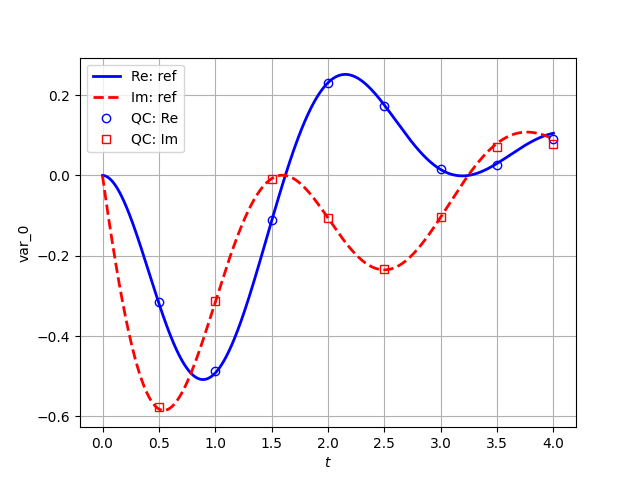

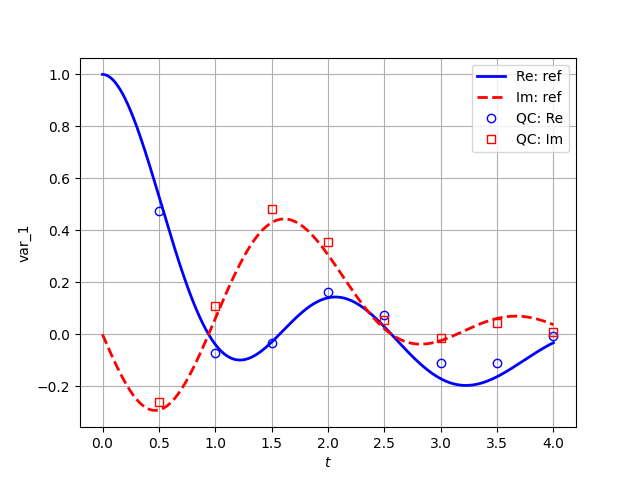

max. abs. err: 6.354e-02


In [6]:
# --------------------------------------------------------
# --- Read results from quantum simulations ---
# --------------------------------------------------------
mix.reload_module(mse)
def plot_QC_vs_REF(t_ref, psi_ref, qt_points, psi_qc, id_var, flag_save):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # --- Plotting ---
    ax.plot(t_ref, psi_ref.real[:,id_var], "-b",  linewidth = 2, label="Re: ref")
    ax.plot(t_ref, psi_ref.imag[:,id_var], "--r", linewidth = 2, label="Im: ref")
    
    ax.plot(
        qt_points, coef_sign_ * psi_qc.real[:,id_var], 
        "o", markerfacecolor='None', markeredgecolor='b', linestyle='None',
        label = "QC: Re"
    )
    ax.plot(
        qt_points, coef_sign_ * psi_qc.imag[:,id_var], 
        "s", markerfacecolor='None', markeredgecolor='r', linestyle='None',
        label = "QC: Im"
    )

    plt.xlabel('$t$')
    plt.ylabel("var_{:d}".format(id_var))
    ax.legend()
    plt.grid(True)
    plt.show()

    if flag_save:
        if sel_case_ == 1:
            str_sel = "WD"
        elif sel_case_ == 2:
            str_sel = "SD"
        else:
            return
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_test_{:s}_kmax{:d}_v{:d}_REF_RE.dat".format(str_sel, int(k_max_), id_var),    
            t_ref, psi_ref.real[:,id_var]
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_test_{:s}_kmax{:d}_v{:d}_REF_IM.dat".format(str_sel, int(k_max_), id_var),    
            t_ref, psi_ref.imag[:,id_var]
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_test_{:s}_kmax{:d}_v{:d}_QC_RE.dat".format(str_sel, int(k_max_), id_var),    
            qt_points, coef_sign_ * psi_qc.real[:,id_var]
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_test_{:s}_kmax{:d}_v{:d}_QC_IM.dat".format(str_sel, int(k_max_), id_var),    
            qt_points, coef_sign_ * psi_qc.imag[:,id_var]
        )
    return
# ------------------------------------------------------------------------------
def read_data(Nt_point):
    print()  
    pro_name_work = "test_{:d}".format(Nt_point)

    # --- Read the _OUTPUT.hdf5 file ---
    om = mse.MeasOracle__()
    om.path_  = path_qucf_
    om.pname_ = pro_name_work
    om.open()
    
    # --- get the result ---
    om.set_zero_ancillae_work_states(0)
    qc_state_t = om.get_var_x({}, "rx")
    
    print("success prob: {:0.12e}".format(
        np.sum(np.abs(qc_state_t)**2)
    ))

    # parameters of the k-grid:
    om.read_qsvt()
    nk_c = om.dd_["regs"]["rk"]
    k_max_c = om.constants_["k_max"]
    print("QuCF: kmax: {:0.3e}".format(k_max_c))
    # Nk_c = 1 << nk_c
    # k_grid = np.linspace(-k_max_c, k_max_c, Nk_c)
    # dk_c = np.diff(k_grid)[0]
    
    print("nk: {:d}".format(nk_c))

    # renormalization:
    Hadamart_norm_factor = 2**(nk_c) 
    coef_norm = Hadamart_norm_factor
    qc_state_t *= coef_norm

    return qc_state_t
# ------------------------------------------------------------------------------
flag_save = False

psi_qc = np.zeros((len(t_qc_), 2), dtype=complex)
for ii in range(len(t_qc_)):
    print()
    psi_one = read_data(ii+1)
    psi_qc[ii, :] = psi_one  

# --- Plotting ---
psi_ref_norm = np.array(psi_ref_)
psi_qc_norm  = np.array(psi_qc)


# ************************************************************************
# These amplification signals are computed in calc-weights.ipynb 
# by comparing non-amplified and amplified sqrt(weights) 
# ************************************************************************
rr = None
if int(k_max_) == 10 and nk_ == 5:
    rr = 5.856193156150e+00
print("rr = {:0.12e}".format(rr))
psi_qc_norm /= rr**2

plot_QC_vs_REF(t_, psi_ref_norm, t_qc_, psi_qc_norm, id_var = 0, flag_save = flag_save)
plot_QC_vs_REF(t_, psi_ref_norm, t_qc_, psi_qc_norm, id_var = 1, flag_save = flag_save)

# --- Compute the error ---
get_max_ABS_err(t_, psi_ref_norm, t_qc_, psi_qc_norm, coef_sign_)
del flag_save